In [39]:
import os

import pandas as pd
import numpy as np
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [2]:
# Helper Functions
def list_feature_values(df):
    '''Function will return Dataframe with Fearure Descriptions: '''
    _ = pd.DataFrame(columns = ['Cardinality', 'Values'])
    for col in df.columns:
        FeatureName = col
        Feature_Cardinality = df[col].nunique()
        Feature_Cardinality_Values = [
            ", ".join(list(map(str, df[col].unique())))
            if df[col].nunique() < 10 
            else f'''{", ".join(list(map(str, df[col].unique()[:10])))}, ...'''
        ]
        _index = _.shape[0]
        _.loc[FeatureName, "Cardinality"] = Feature_Cardinality
        _.loc[FeatureName, "Values"] = Feature_Cardinality_Values
        _.loc[FeatureName, 'Null Values'] = round(100*(df[col].isna().sum()/df.shape[0]), 2)
    return _

In [3]:
df = pd.read_parquet(r'../dataset/churn.parquet')
df.head(3)

,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,XW0DQ7H,Village,Platinum Membership,17-08-2017,No,xxxxxxxx,Gift Vouchers/Coupons,?,...,300.63,53005.25,17,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,32,F,5K0N3X1,City,Premium Membership,28-08-2017,?,CID21329,Gift Vouchers/Coupons,Desktop,...,306.34,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,44,F,1F2TCL3,Town,No Membership,11-11-2016,Yes,CID12313,Gift Vouchers/Coupons,Desktop,...,516.16,21027.00,22,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1


In [4]:
print('count: Records:', df.shape[0])
print('count: features:', df.shape[1], end = '\n\n')


count: Records: 36992
count: features: 23



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36992 non-null  int64  
 1   gender                        36992 non-null  object 
 2   security_no                   36992 non-null  object 
 3   region_category               31564 non-null  object 
 4   membership_category           36992 non-null  object 
 5   joining_date                  36992 non-null  object 
 6   joined_through_referral       36992 non-null  object 
 7   referral_id                   36992 non-null  object 
 8   preferred_offer_types         36704 non-null  object 
 9   medium_of_operation           36992 non-null  object 
 10  internet_option               36992 non-null  object 
 11  last_visit_time               36992 non-null  object 
 12  days_since_last_login         36992 non-null  int64  
 13  a

In [6]:
# Checking NA Values
round(100*((df.isna() | df.isnull()).sum()/df.shape[0]), 2)

age                              0.00
gender                           0.00
security_no                      0.00
region_category                 14.67
membership_category              0.00
joining_date                     0.00
joined_through_referral          0.00
referral_id                      0.00
preferred_offer_types            0.78
medium_of_operation              0.00
internet_option                  0.00
last_visit_time                  0.00
days_since_last_login            0.00
avg_time_spent                   0.00
avg_transaction_value            0.00
avg_frequency_login_days         0.00
points_in_wallet                 9.31
used_special_discount            0.00
offer_application_preference     0.00
past_complaint                   0.00
complaint_status                 0.00
feedback                         0.00
churn_risk_score                 0.00
dtype: float64

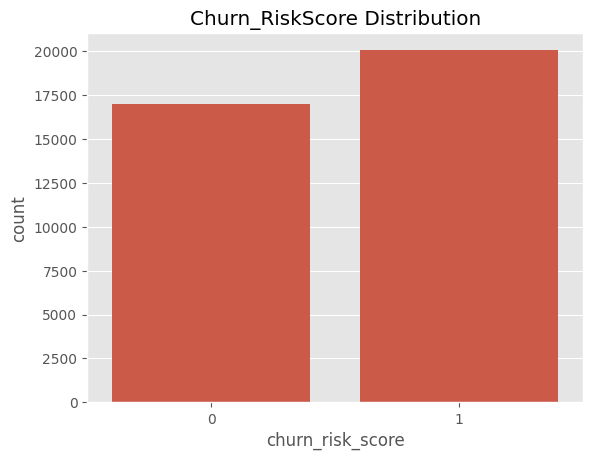

<Figure size 1200x800 with 0 Axes>

In [7]:
sns.countplot(x='churn_risk_score', data=df, orient = 'h')

plt.title('Churn_RiskScore Distribution')
plt.figure(figsize=(12, 8))
plt.show()

<Figure size 1200x800 with 0 Axes>

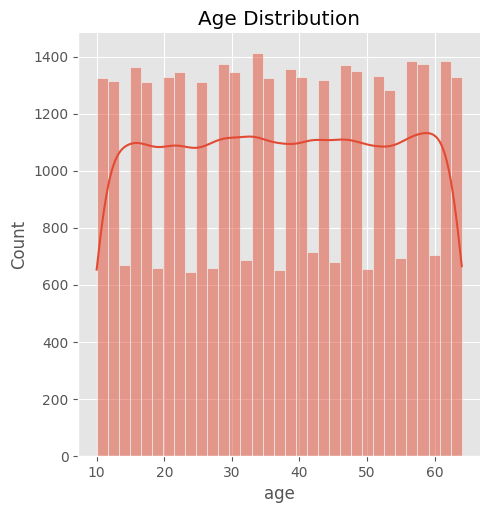

In [8]:
plt.figure(figsize=(12, 8))
sns.displot(df['age'], kde = True, )
plt.title('Age Distribution')
plt.show()

Text(0.5, 1.0, 'Distribution of Avg_transaction_value vs Age')

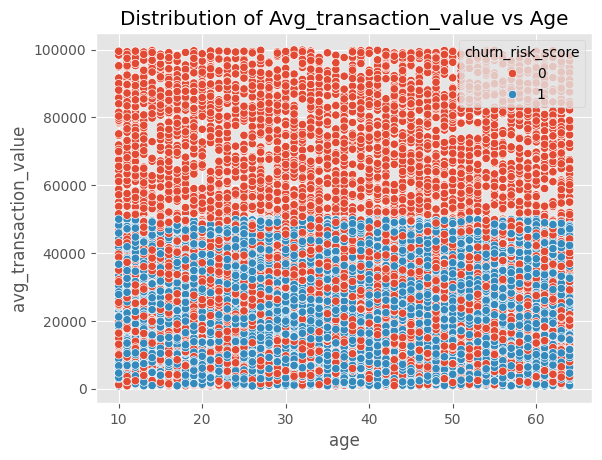

In [9]:
sns.scatterplot(data = df, x = 'age', y = 'avg_transaction_value', hue = 'churn_risk_score')
plt.title('Distribution of Avg_transaction_value vs Age')

From the scatter plot, we can observe that higher average transaction values seem to be associated with a lower churn risk score (red points). In other words:

 - Red points (lower churn risk score) are more concentrated in the higher range of transaction values (closer to 60,000–100,000).
 - Blue points (higher churn risk score) are mostly found in the lower transaction value range (closer to 0–40,000).

This suggests that people with higher transaction values tend to have a lower likelihood of churning (churn risk score = 0), whereas those with lower transaction values are more likely to churn (churn risk score = 1).
This pattern implies that customers with higher spending might be more loyal or engaged, while those with lower spending might be at higher risk of leaving.

 - But it doesn't show strong corelation which means it also depends on other factors

Text(0.5, 1.0, 'Distribution: Avg Time Spent')

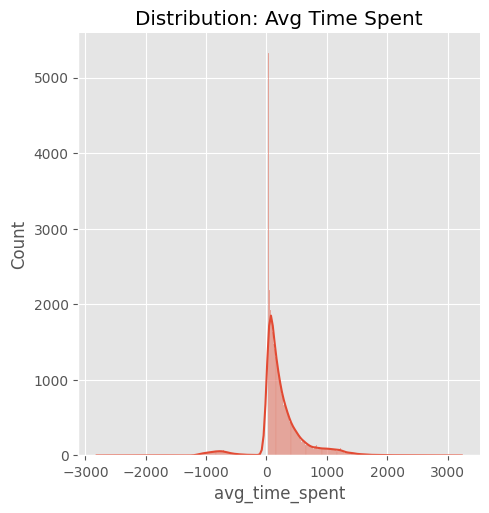

In [10]:
sns.displot(df['avg_time_spent'], kde = True)
plt.title('Distribution: Avg Time Spent')

Avg. Time Spent cannot be negative value:
 - Data Error: During record of data or system error
 - Time Diffrence Calculations: Calculating Time diffrence accross diffrent timezone may result in negative time spent

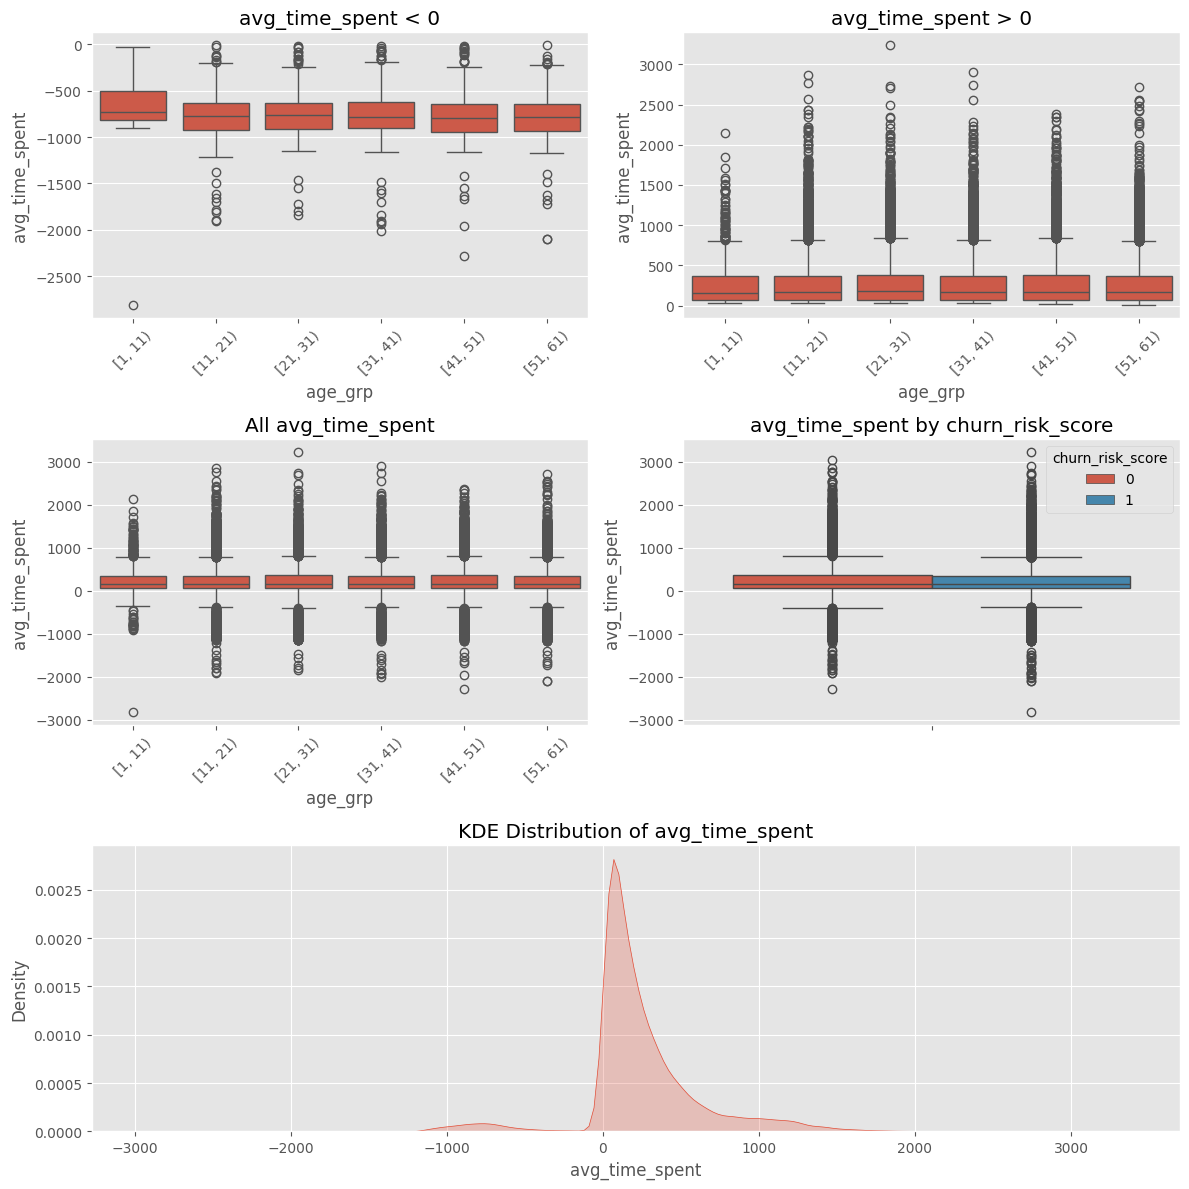

In [67]:
import matplotlib.gridspec as gridspec


# Adding Column: Age_grp
age_grp = range(1, df.age.max())[::10]
df['age_grp'] = pd.cut(df['age'], bins = age_grp, right = False, ordered=True)

# Create subplots using GridSpec to span the KDE across both columns
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Boxplot avg_time_spent < 0
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(data=df[df['avg_time_spent'] < 0], x='age_grp', y='avg_time_spent', ax=ax1)
ax1.set_title('avg_time_spent < 0')
ax1.tick_params(axis='x', rotation=45)

# Boxplot avg_time_spent > 0
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(data=df[df['avg_time_spent'] > 0], x='age_grp', y='avg_time_spent', ax=ax2)
ax2.set_title('avg_time_spent > 0')
ax2.tick_params(axis='x', rotation=45)

# Boxplot all data
ax3 = fig.add_subplot(gs[1, 0])
sns.boxplot(data=df, x='age_grp', y='avg_time_spent', ax=ax3)
ax3.set_title('All avg_time_spent')
ax3.tick_params(axis='x', rotation=45)

# Boxplot by churn risk
ax4 = fig.add_subplot(gs[1, 1])
sns.boxplot(data=df, y='avg_time_spent', ax=ax4, hue='churn_risk_score')
ax4.set_title('avg_time_spent by churn_risk_score')

# KDE Distribution across both columns
ax5 = fig.add_subplot(gs[2, :])  # This spans all columns
sns.kdeplot(data=df, x='avg_time_spent', ax=ax5, fill=True)
ax5.set_title('KDE Distribution of avg_time_spent')

plt.tight_layout()
plt.show()

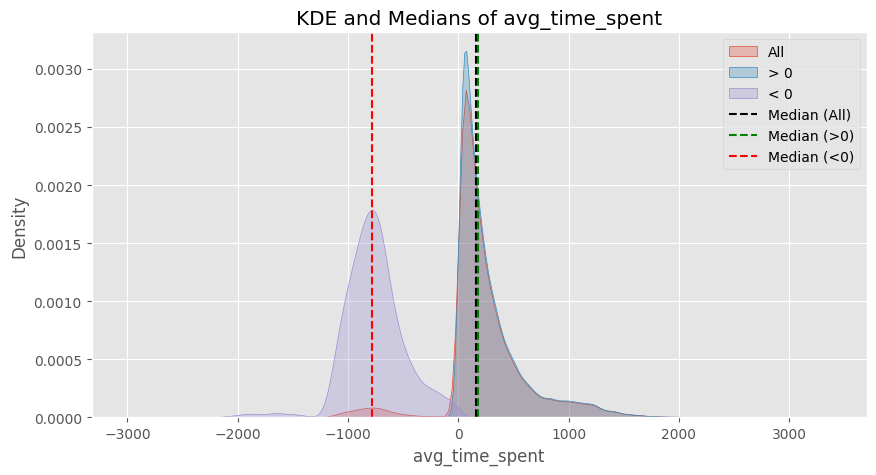

In [68]:

plt.figure(figsize=(10, 5))

sns.kdeplot(df['avg_time_spent'], label='All', fill=True, alpha=0.3)
sns.kdeplot(df[df['avg_time_spent'] > 0]['avg_time_spent'], label='> 0', fill=True, alpha=0.3)
sns.kdeplot(df[df['avg_time_spent'] < 0]['avg_time_spent'], label='< 0', fill=True, alpha=0.3)

plt.axvline(df['avg_time_spent'].median(), color='black', linestyle='--', label='Median (All)')
plt.axvline(df[df['avg_time_spent'] > 0]['avg_time_spent'].median(), color='green', linestyle='--', label='Median (>0)')
plt.axvline(df[df['avg_time_spent'] < 0]['avg_time_spent'].median(), color='red', linestyle='--', label='Median (<0)')

plt.legend()
plt.title('KDE and Medians of avg_time_spent')
plt.show()

In [69]:
print(f"Negative avg_time_spent: {len(df[df['avg_time_spent'] < 0]) / len(df):.1%}")
print(f"Positive avg_time_spent: {len(df[df['avg_time_spent'] > 0]) / len(df):.1%}")

Negative avg_time_spent: 4.6%
Positive avg_time_spent: 95.4%


In [70]:
df[df['avg_time_spent'] < 0]['churn_risk_score'].value_counts(normalize=True)


churn_risk_score
1    0.560209
0    0.439791
Name: proportion, dtype: float64

In [105]:
df[df['avg_time_spent'] < 0].groupby('age_grp').agg({
    'avg_time_spent': ['count', 'mean', 'max', 'min']
})

C:\Users\Ashu\AppData\Local\Temp\ipykernel_6872\2692560318.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['avg_time_spent'] < 0].groupby('age_grp').agg({


avg_time_spent                                    
                  count        mean        max          min
age_grp                                                    
[1, 11)              27 -701.495498 -27.807264 -2814.109110
[11, 21)            323 -777.609265 -12.338460 -1908.578118
[21, 31)            328 -756.321281 -20.349108 -1837.008370
[31, 41)            305 -766.840511 -23.766198 -2012.267374
[41, 51)            294 -776.006597 -23.857065 -2281.236526
[51, 61)            321 -780.707850 -13.589828 -2096.580681

In [81]:
df[df['avg_time_spent'] > 0].groupby('age_grp').agg({
    'avg_time_spent': ['count', 'mean', 'min', 'max']
})

C:\Users\Ashu\AppData\Local\Temp\ipykernel_6872\2927027984.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['avg_time_spent'] > 0].groupby('age_grp').agg({


avg_time_spent                                    
                  count        mean        min          max
age_grp                                                    
[1, 11)             643  284.410233  30.160000  2144.400000
[11, 21)           6294  289.782087  30.000000  2861.230000
[21, 31)           6407  296.694508  29.837667  3235.578521
[31, 41)           6389  294.520639  29.990000  2899.660000
[41, 51)           6494  294.068761  15.114910  2376.050170
[51, 61)           6453  287.466087   1.837399  2722.077794

In [ ]:

sns.catplot(data = df, x = 'age_grp', y = 'avg_time_spent', hue = 'churn_risk_score', orient= 'h')
plt.show()

In [103]:
df['']

0           17
1           10
2           22
3            6
4           16
         ...  
36987        6
36988       28
36989    Error
36990       20
36991    Error
Name: avg_frequency_login_days, Length: 36992, dtype: object